In [1]:
import pandas as pd
from mmcv import Config
from utils import *

config_path = '/Users/KC/My Drive/soundmouse/config/cfg_setting.py'
cfg = Config.fromfile(config_path)
filename = 'data.csv'
path = cfg.filepath_save + filename
data = pd.read_csv(path)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,live,outlier
0,-1.509609,-0.950819,1.371512,-1.484222,0.640996,-0.381994,1.196042,2.235733,2.802696,-1.827616,-1.154106,4.978012,0.292319,0,1
1,1.588714,-0.458713,0.515464,-0.133135,0.640996,1.764213,0.532930,-0.538791,-0.250113,1.637829,-1.805774,-0.384110,0.292319,0,0
2,-1.228465,-1.121164,-0.625932,-0.558317,0.640996,-0.397308,1.140341,2.346335,-0.606778,-1.904319,-0.197504,2.247228,0.292319,0,0
3,-1.532560,-0.579847,-0.055234,0.418419,0.640996,-0.388801,1.156256,-0.538704,1.085869,-1.422624,-0.530532,-0.141447,-1.633903,0,1
4,-0.712078,-1.018957,-0.625932,0.280751,0.640996,-0.374054,1.129731,-0.538786,0.167003,-1.085130,-0.479878,-0.498083,0.292319,0,0


In [2]:
#basic info
fprint('outlier', data['outlier'].sum())
fprint('data shape',data.shape)
fprint('data shape [train]', data.drop(columns=cfg.drop_cols).shape)
fprint('data shape [label]', data[cfg.label_col].shape)

outlier             : 24747 
data shape          : (99000, 15) 
data shape [train]  : (99000, 13) 
data shape [label]  : (99000,) 


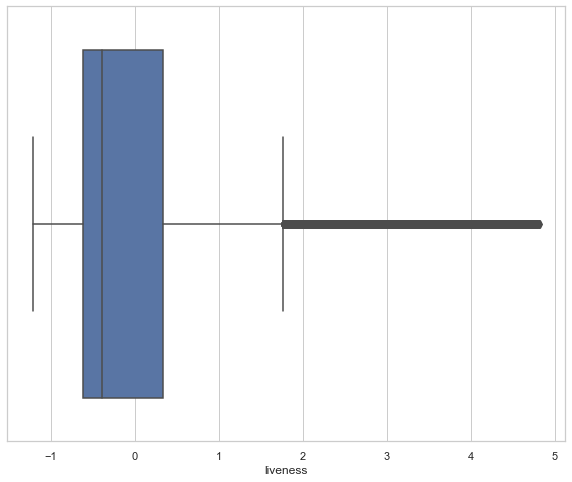

In [3]:
plot(df=data, x='liveness', plot_type='boxplot')

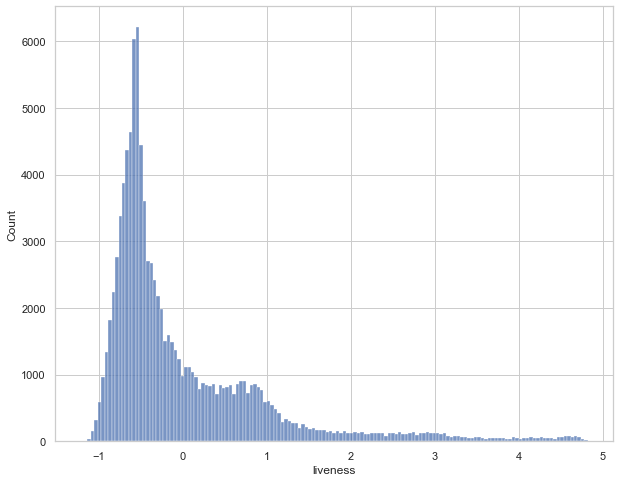

In [4]:
plot(df=data, x='liveness', plot_type='histplot')

In [5]:
df_print_info(data, 'liveness')

[max/min/mean  ]----------------------------------------
liveness max  : 4.8217818995868384 
liveness min  : -1.2173400946427997 
liveness mean : 4.721774037981196e-15 
[quantile      ]----------------------------------------
0.05   -0.854026
0.25   -0.617660
0.50   -0.395197
0.75    0.336268
0.95    2.216315
Name: liveness, dtype: float64


data is transformed from dataframe to numpy(matrix)

(99000, 14)
0  ...
1  ...
2  ...
3  ...
4  ...
5  ...
6  ...
7  ...
8  ...
9  ...
10  ...
11  ...
12  ...
13  ...


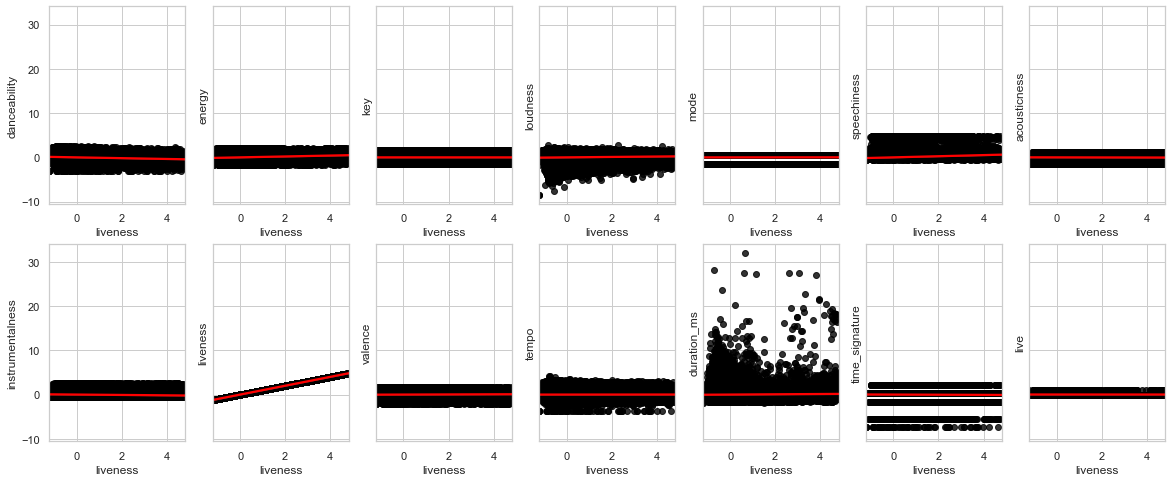

In [7]:
plot_data = data.drop(columns=['outlier'])
print(plot_data.shape)
multi_plot(plot_data, col_name='liveness', cols=7, rows=2)

In [8]:
corr = data.corr()
corr['outlier']

danceability       -0.050251
energy              0.119775
key                -0.001366
loudness            0.073484
mode               -0.000725
speechiness         0.117753
acousticness       -0.048837
instrumentalness   -0.061490
liveness            0.784705
valence             0.050513
tempo               0.009524
duration_ms         0.000636
time_signature     -0.009322
live                0.007537
outlier             1.000000
Name: outlier, dtype: float64

# Imbalanced data

## PCA before SMOTE

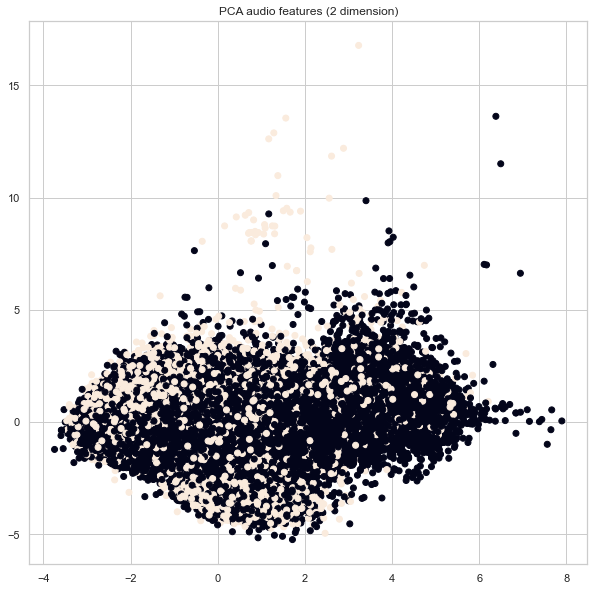

In [9]:
# PCA
from sklearn.decomposition import PCA
pca_y = data[cfg.label_col]
pca_x = data.drop(columns=cfg.drop_cols)
pca_y = pca_y.to_numpy().reshape(-1)
pca_x = pca_x.to_numpy()


pca = PCA(n_components=2)
pca.fit(pca_x)
pca_x = pca.transform(pca_x)
fig = plt.figure(1, figsize=(10, 10))
plt.scatter(pca_x[:,0],pca_x[:,1],c=pca_y)
plt.title('PCA audio features (2 dimension)')
plt.show()

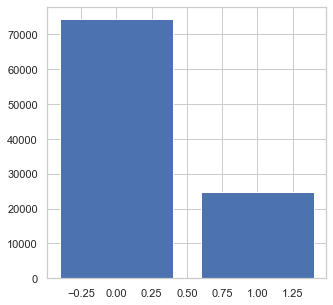

before SMOTE        : Counter({0: 74253, 1: 24747}) 


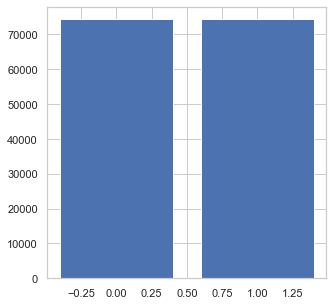

after SMOTE         : Counter({1: 74253, 0: 74253}) 
data columns        : Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object') 


In [27]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
y = data[cfg.label_col]
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()
fprint('before SMOTE', counter)

oversampling=SMOTE(k_neighbors=1)

x=data.drop(columns=cfg.drop_cols)
x,y = oversampling.fit_resample(x, y)
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()
fprint('after SMOTE', counter)
fprint('data columns', x.keys())

### Transfromed dataframe to numpy

In [28]:
keys = x.keys()
x = x.to_numpy()
y = y.to_numpy().reshape(-1)
print(x.shape)
print(y.shape)

(148506, 13)
(148506,)


## PCA after SMOTE

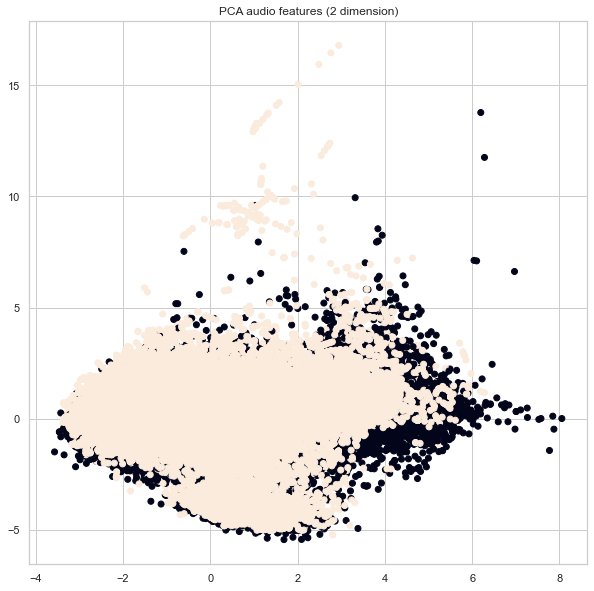

In [29]:
pca_y = y
pca_x = x
# pca_y = pca_y.to_numpy().reshape(-1)
# pca_x = pca_x.to_numpy()

pca = PCA(n_components=2)
pca.fit(pca_x)
pca_x = pca.transform(pca_x)
fig = plt.figure(1, figsize=(10, 10))
plt.scatter(pca_x[:,0],pca_x[:,1],c=pca_y)
plt.title('PCA audio features (2 dimension)')
plt.show()

# split

In [30]:
from sklearn.model_selection import train_test_split

x_tr, x_tt, y_tr, y_tt = train_test_split(x, y, test_size=0.2)
print(x_tr.shape, x_tt.shape, y_tr.shape, y_tt.shape)

(118804, 13) (29702, 13) (118804,) (29702,)


# XGBCclassfier

In [31]:
import xgboost as xgb
import numpy as np
model = xgb.XGBClassifier()
model.fit(x_tr, y_tr)
print(model)

pred = model.predict_proba(x_tt)[:,1]
fprint('prob pred', pred[:10])
y_pred = np.where(pred>=0.5, 1, 0)
fprint('predictions', y_pred[:10])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
prob pred           : [9.9733597e-01 5.5136316e-04 9.9862778e-01 1.1706103e-03 9.9976510e-01
 1.8109927e-03 9.9585849e-01 9.9990714e-01 9.9945194e-01 1.0618834e-03] 
predictions         : [1 0 1 0 1 0 1 1 1 0] 


In [32]:
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
#declare cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=71)
train_x = x_tr
train_y = y_tr

res_accuracy = []
res_logloss = []
for k, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
    print(f'{k} fold...')
    tr_x, va_x = train_x[tr_idx], train_x[va_idx]
    tr_y, va_y = train_y[tr_idx], train_y[va_idx]
    
    model = xgb.XGBClassifier()
    model.fit(tr_x, tr_y)
    
    va_pred = model.predict_proba(va_x)[:, 1]
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)
    res_logloss.append(logloss)
    res_accuracy.append(accuracy)
    
logloss = np.mean(res_logloss)
accuracy = np.mean(res_accuracy)
print(f'logloss: {logloss:.4f}, accuracy: {accuracy:.4f}')


0 fold...
1 fold...
2 fold...
3 fold...
logloss: 0.0362, accuracy: 0.9923


In [33]:
def print_keys(keys):
    for i, key in enumerate(keys):
        print("{} : {}".format(i, key))

0 : danceability
1 : energy
2 : key
3 : loudness
4 : mode
5 : speechiness
6 : acousticness
7 : instrumentalness
8 : liveness
9 : valence
10 : tempo
11 : duration_ms
12 : time_signature


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

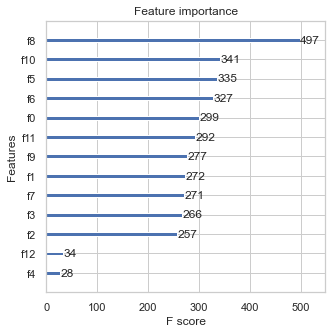

In [34]:
print_keys(keys)
xgb.plot_importance(model)
# xgb.plot_importance(model._Booster)

In [35]:
import graphviz
dot = graphviz.Digraph('round-table', comment='The Round Table')  
# dot

0 : danceability
1 : energy
2 : key
3 : loudness
4 : mode
5 : speechiness
6 : acousticness
7 : instrumentalness
8 : liveness
9 : valence
10 : tempo
11 : duration_ms
12 : time_signature


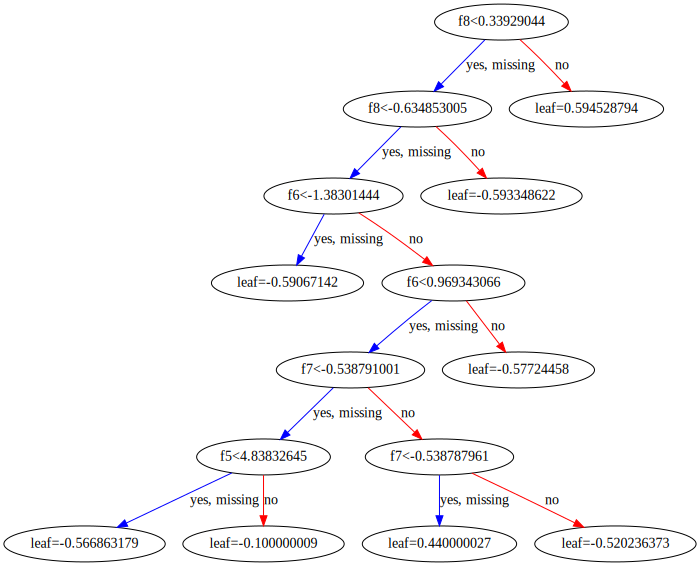

In [36]:
print_keys(keys)
xgb.to_graphviz(model)

In [40]:
live_data = data[data['live']==1]
print(live_data['liveness'].max())

4.743194726488755


In [37]:
df_print_info(data, 'liveness')

[max/min/mean  ]----------------------------------------
liveness max  : 4.8217818995868384 
liveness min  : -1.2173400946427997 
liveness mean : 4.721774037981196e-15 
[quantile      ]----------------------------------------
0.05   -0.854026
0.25   -0.617660
0.50   -0.395197
0.75    0.336268
0.95    2.216315
Name: liveness, dtype: float64


In [38]:
y_true = y_tt
acc = accuracy_score(y_true, y_pred)
fprint('accuracy(%)',acc)

accuracy(%)         : 0.9919534038111911 


[[14782    76]
 [  163 14681]]


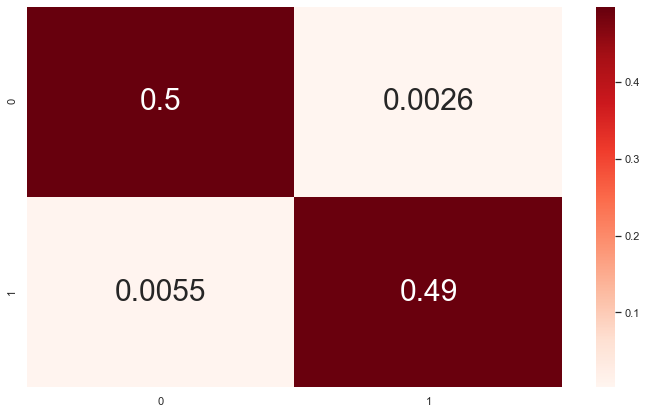

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

classes = [0,1]
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap = "Reds", annot=True, annot_kws={"size": 30})
plt.savefig('output.png')

# deep learning

In [415]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
import numpy as np

In [416]:
#build dataset
class custom_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        data = torch.Tensor(self.x[idx])
        label = torch.Tensor(self.y[idx].reshape(-1))
        
        return data, label
        
    
train_dataset = custom_dataset(x_tr, y_tr)
test_dataset = custom_dataset(x_tt, y_tt)
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

print(len(train_dataset))
print(len(test_dataset))

for i, (data, label) in enumerate(train_dataloader):
    x = data
    y = label
    print('x: ',type(x), x)
    print('y: ',type(y), y)
    
    if i > 1:
        break
    


118804
29702
x:  <class 'torch.Tensor'> tensor([[-0.0809,  0.6921, -1.4820,  0.3955,  0.6410, -0.0700,  0.6762, -0.5388,
         -0.9507,  0.8440,  1.1393, -0.7018,  0.2923],
        [-1.3719, -1.6962,  1.3715, -1.4247, -1.5601, -0.3525,  1.1059, -0.2405,
         -0.7386, -1.4533,  1.7916,  0.2560, -1.6339],
        [ 0.3704, -0.2821, -1.4820,  0.1957,  0.6410, -0.3417, -0.2787, -0.5388,
          1.2189,  0.1140,  0.0190, -0.1074,  0.2923],
        [ 0.6420,  0.7943, -1.4820,  1.0072, -1.5601,  1.1743, -0.1594, -0.5388,
         -0.7452, -0.7400,  2.1307,  0.1840,  0.2923],
        [ 0.0432, -1.2235,  0.6105, -0.7305, -1.5601, -0.1965,  1.2243,  2.2683,
         -0.4618, -0.5150, -1.1462, -0.3662,  0.2923],
        [-0.5801,  0.6050, -1.1966,  1.4119,  0.6410, -0.1954,  0.6762, -0.5388,
         -0.5524,  0.1498,  2.2933, -0.2430, -1.6339],
        [ 1.0838,  0.2832,  1.6569,  0.6833,  0.6410, -0.4087,  0.7425, -0.5388,
         -0.3771,  1.3655,  0.3720, -0.8901,  0.2923],
        

In [417]:
#define model
class Net(nn.Module):
    def __init__(self, cfg_model):
        super(Net, self).__init__()
        info = cfg_model
        l1 = info['l1']
        l2 = info['l2']
        l3 = info['l3']
        l4 = info['l4']
        self.dropout = info['dropout']
        self.fc1 = nn.Linear(l1[0], l1[1])
        self.fc2 = nn.Linear(l2[0], l2[1])
        self.fc3 = nn.Linear(l3[0], l3[1])
        self.fc4 = nn.Linear(l4[0], l4[1])
        
        self.BCEloss=nn.BCELoss()
        
    def forward(self, x):
        # print(x.shape)
        x = torch.unsqueeze(x, 0)
        
        x = torch.sigmoid(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x 
    
    def loss_fn(self, y_pred, y_true):
        y_pred = y_pred.view(-1).float()
        # y_pred = np.where(y_pred>0.5, 1, 0)
        y_true = y_true.view(-1).float()
        # print(y_pred, y_true)
        # print(y_pred.size(), y_true.size())
        loss = self.BCEloss(y_pred, y_true)
        return loss
        
model = Net(cfg.model)
test_pred=model(x)
loss = model.loss_fn(test_pred, y)
print(test_pred, loss)

tensor([[[0.4431],
         [0.4432],
         [0.4433],
         [0.4436],
         [0.4432],
         [0.4434],
         [0.4435],
         [0.4438],
         [0.4433],
         [0.4436],
         [0.4440],
         [0.4428],
         [0.4435],
         [0.4435],
         [0.4433],
         [0.4440]]], grad_fn=<SigmoidBackward0>) tensor(0.6710, grad_fn=<BinaryCrossEntropyBackward0>)


In [418]:
model = Net(cfg.model)
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
print(optimizer)

Net(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (fc2): Linear(in_features=26, out_features=13, bias=True)
  (fc3): Linear(in_features=13, out_features=6, bias=True)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
  (BCEloss): BCELoss()
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-06
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [419]:
config_path = '/Users/KC/My Drive/soundmouse/cfg_setting.py'
cfg = Config.fromfile(config_path)

epochs = cfg.epochs
fprint('epochs', epochs)
model.train()
for epoch in range(epochs):
    fprint('epoch', epoch)
    for i, (x, y_true) in tqdm(enumerate(train_dataloader)):
        y_pred = model(x)
        loss = model.loss_fn(y_pred, y_true)
        if i % cfg.interval == cfg.interval-1:
            print(epoch, loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    

39it [00:00, 385.94it/s]

epochs              : 10 
epoch               : 0 


1096it [00:02, 448.80it/s]

0 tensor(0.6621, grad_fn=<BinaryCrossEntropyBackward0>)


2099it [00:04, 695.15it/s]

0 tensor(0.7366, grad_fn=<BinaryCrossEntropyBackward0>)


2984it [00:05, 643.97it/s]

0 tensor(0.6621, grad_fn=<BinaryCrossEntropyBackward0>)


4037it [00:08, 381.33it/s]

0 tensor(0.8104, grad_fn=<BinaryCrossEntropyBackward0>)


5154it [00:09, 627.15it/s]

0 tensor(0.8845, grad_fn=<BinaryCrossEntropyBackward0>)


6106it [00:11, 676.78it/s]

0 tensor(0.7735, grad_fn=<BinaryCrossEntropyBackward0>)


7090it [00:12, 923.28it/s]

0 tensor(0.7731, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:13, 543.31it/s]
9it [00:00, 88.66it/s]

epoch               : 1 


1036it [00:02, 558.18it/s]

1 tensor(0.6620, grad_fn=<BinaryCrossEntropyBackward0>)


2120it [00:03, 807.56it/s]

1 tensor(0.7362, grad_fn=<BinaryCrossEntropyBackward0>)


3129it [00:05, 731.23it/s]

1 tensor(0.6621, grad_fn=<BinaryCrossEntropyBackward0>)


4143it [00:07, 830.21it/s]

1 tensor(0.8097, grad_fn=<BinaryCrossEntropyBackward0>)


5105it [00:08, 656.63it/s]

1 tensor(0.8835, grad_fn=<BinaryCrossEntropyBackward0>)


6148it [00:10, 907.62it/s]

1 tensor(0.7730, grad_fn=<BinaryCrossEntropyBackward0>)


7067it [00:12, 353.72it/s]

1 tensor(0.7726, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:12, 571.74it/s]
56it [00:00, 556.01it/s]

epoch               : 2 


1069it [00:02, 449.79it/s]

2 tensor(0.6620, grad_fn=<BinaryCrossEntropyBackward0>)


2089it [00:04, 384.52it/s]

2 tensor(0.7358, grad_fn=<BinaryCrossEntropyBackward0>)


3019it [00:06, 459.22it/s]

2 tensor(0.6620, grad_fn=<BinaryCrossEntropyBackward0>)


4044it [00:08, 671.88it/s]

2 tensor(0.8090, grad_fn=<BinaryCrossEntropyBackward0>)


5124it [00:10, 720.03it/s]

2 tensor(0.8825, grad_fn=<BinaryCrossEntropyBackward0>)


6011it [00:11, 723.79it/s]

2 tensor(0.7724, grad_fn=<BinaryCrossEntropyBackward0>)


7083it [00:14, 530.87it/s]

2 tensor(0.7721, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:15, 484.96it/s]
29it [00:00, 285.71it/s]

epoch               : 3 


1058it [00:03, 273.60it/s]

3 tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward0>)


2100it [00:05, 679.93it/s]

3 tensor(0.7355, grad_fn=<BinaryCrossEntropyBackward0>)


3037it [00:08, 241.11it/s]

3 tensor(0.6620, grad_fn=<BinaryCrossEntropyBackward0>)


4039it [00:10, 580.92it/s]

3 tensor(0.8083, grad_fn=<BinaryCrossEntropyBackward0>)


5030it [00:12, 513.08it/s]

3 tensor(0.8815, grad_fn=<BinaryCrossEntropyBackward0>)


6076it [00:14, 627.68it/s]

3 tensor(0.7719, grad_fn=<BinaryCrossEntropyBackward0>)


7056it [00:17, 375.68it/s]

3 tensor(0.7715, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:17, 423.10it/s]
17it [00:00, 135.89it/s]

epoch               : 4 


1136it [00:02, 686.03it/s]

4 tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward0>)


2110it [00:04, 703.95it/s]

4 tensor(0.7351, grad_fn=<BinaryCrossEntropyBackward0>)


3107it [00:06, 461.77it/s]

4 tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward0>)


4097it [00:07, 659.59it/s]

4 tensor(0.8076, grad_fn=<BinaryCrossEntropyBackward0>)


5173it [00:09, 878.14it/s]

4 tensor(0.8805, grad_fn=<BinaryCrossEntropyBackward0>)


6141it [00:12, 668.37it/s]

4 tensor(0.7714, grad_fn=<BinaryCrossEntropyBackward0>)


7077it [00:14, 748.44it/s]

4 tensor(0.7710, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:14, 505.59it/s]
11it [00:00, 68.22it/s]

epoch               : 5 


1078it [00:02, 588.60it/s]

5 tensor(0.6618, grad_fn=<BinaryCrossEntropyBackward0>)


2039it [00:04, 464.19it/s]

5 tensor(0.7348, grad_fn=<BinaryCrossEntropyBackward0>)


3064it [00:07, 516.95it/s]

5 tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward0>)


4128it [00:08, 613.28it/s]

5 tensor(0.8069, grad_fn=<BinaryCrossEntropyBackward0>)


5095it [00:10, 679.22it/s]

5 tensor(0.8795, grad_fn=<BinaryCrossEntropyBackward0>)


6146it [00:12, 729.16it/s]

5 tensor(0.7709, grad_fn=<BinaryCrossEntropyBackward0>)


7153it [00:14, 724.28it/s]

5 tensor(0.7705, grad_fn=<BinaryCrossEntropyBackward0>)


7426it [00:14, 497.06it/s]
48it [00:00, 475.66it/s]

epoch               : 6 


1062it [00:01, 556.44it/s]

6 tensor(0.6618, grad_fn=<BinaryCrossEntropyBackward0>)


2056it [00:03, 433.24it/s]

6 tensor(0.7344, grad_fn=<BinaryCrossEntropyBackward0>)


3082it [00:05, 588.02it/s]

6 tensor(0.6618, grad_fn=<BinaryCrossEntropyBackward0>)


3224it [00:06, 535.77it/s]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    test_y_pred=[]
    test_y_true=[]
    for i, (x, y_true) in tqdm(enumerate(test_dataloader)):
        y_pred = model(x)
        test_y_pred.append(y_pred)
        test_y_true.append(y_true)
        loss = model.loss_fn(y_pred, y_true)
        print(loss)
        

41it [00:00, 407.27it/s]

tensor(0.7643)
tensor(0.6881)
tensor(0.6881)
tensor(0.8156)
tensor(0.6374)
tensor(0.7400)
tensor(0.7390)
tensor(0.7392)
tensor(0.7136)
tensor(0.7134)
tensor(0.6631)
tensor(0.7391)
tensor(0.7392)
tensor(0.7645)
tensor(0.6883)
tensor(0.7136)
tensor(0.7136)
tensor(0.7394)
tensor(0.6882)
tensor(0.7391)
tensor(0.6627)
tensor(0.7389)
tensor(0.7138)
tensor(0.6882)
tensor(0.7143)
tensor(0.7645)
tensor(0.7136)
tensor(0.6110)
tensor(0.7397)
tensor(0.7135)
tensor(0.7646)
tensor(0.6881)
tensor(0.7391)
tensor(0.7389)
tensor(0.6623)
tensor(0.7390)
tensor(0.8412)
tensor(0.7643)
tensor(0.7138)
tensor(0.7135)
tensor(0.7899)
tensor(0.6883)
tensor(0.7130)
tensor(0.7650)
tensor(0.6628)
tensor(0.7136)
tensor(0.7391)
tensor(0.7902)
tensor(0.6878)
tensor(0.6884)
tensor(0.6371)
tensor(0.6117)
tensor(0.6883)
tensor(0.7648)
tensor(0.6371)
tensor(0.6881)
tensor(0.7129)
tensor(0.7644)
tensor(0.7898)
tensor(0.6627)
tensor(0.6881)
tensor(0.7644)
tensor(0.6881)
tensor(0.7387)
tensor(0.6881)
tensor(0.7140)
tensor(0.6

115it [00:00, 302.90it/s]


tensor(0.6878)
tensor(0.7390)
tensor(0.7133)
tensor(0.7395)
tensor(0.7394)
tensor(0.6622)
tensor(0.7645)
tensor(0.6881)
tensor(0.7391)
tensor(0.6118)
tensor(0.7135)
tensor(0.8153)
tensor(0.7391)
tensor(0.6884)
tensor(0.6626)
tensor(0.7391)
tensor(0.7644)
tensor(0.7899)
tensor(0.7389)
tensor(0.7389)
tensor(0.7135)
tensor(0.7394)
tensor(0.6622)
tensor(0.6627)
tensor(0.7643)
tensor(0.6373)
tensor(0.7642)
tensor(0.6367)
tensor(0.7131)
tensor(0.7391)
tensor(0.7397)
tensor(0.7647)
tensor(0.7138)
tensor(0.7394)
tensor(0.7902)
tensor(0.6884)
tensor(0.7138)
tensor(0.7129)
tensor(0.7133)
tensor(0.7393)
tensor(0.6369)
tensor(0.7135)
tensor(0.7135)
tensor(0.6879)
tensor(0.7131)
tensor(0.7136)
tensor(0.6625)
tensor(0.7389)
tensor(0.7135)
tensor(0.7140)
tensor(0.7388)
tensor(0.7136)
tensor(0.6882)
tensor(0.7395)
tensor(0.6880)
tensor(0.7137)
tensor(0.6366)
tensor(0.7135)
tensor(0.6879)
tensor(0.6881)
tensor(0.7393)
tensor(0.6879)
tensor(0.7139)
tensor(0.7137)
tensor(0.6626)
tensor(0.6622)
tensor(0.

274it [00:00, 571.28it/s]

tensor(0.7648)
tensor(0.7390)
tensor(0.7646)
tensor(0.6115)
tensor(0.7136)
tensor(0.6111)
tensor(0.7648)
tensor(0.8157)
tensor(0.6881)
tensor(0.7648)
tensor(0.7396)
tensor(0.7140)
tensor(0.7391)
tensor(0.7903)
tensor(0.6881)
tensor(0.6629)
tensor(0.7394)
tensor(0.6885)
tensor(0.7393)
tensor(0.7138)
tensor(0.7388)
tensor(0.6880)
tensor(0.6632)
tensor(0.7646)
tensor(0.7900)
tensor(0.7145)
tensor(0.6626)
tensor(0.7639)
tensor(0.7645)
tensor(0.7387)
tensor(0.6631)
tensor(0.6626)
tensor(0.6631)
tensor(0.6885)
tensor(0.7134)
tensor(0.6880)
tensor(0.6626)
tensor(0.6879)
tensor(0.7393)
tensor(0.7904)
tensor(0.6115)
tensor(0.7644)
tensor(0.7394)
tensor(0.7397)
tensor(0.7134)
tensor(0.7396)
tensor(0.6623)
tensor(0.7393)
tensor(0.7645)
tensor(0.7387)
tensor(0.7133)
tensor(0.7134)
tensor(0.7388)
tensor(0.6628)
tensor(0.7645)
tensor(0.7391)
tensor(0.6878)
tensor(0.7386)
tensor(0.6625)
tensor(0.6625)
tensor(0.7134)
tensor(0.7130)
tensor(0.7904)
tensor(0.7390)
tensor(0.6883)
tensor(0.7643)
tensor(0.6

428it [00:00, 673.16it/s]

tensor(0.8154)
tensor(0.7393)
tensor(0.6882)
tensor(0.6879)
tensor(0.6629)
tensor(0.7642)
tensor(0.7643)
tensor(0.6887)
tensor(0.7648)
tensor(0.7646)
tensor(0.7137)
tensor(0.7389)
tensor(0.7138)
tensor(0.6371)
tensor(0.7389)
tensor(0.7397)
tensor(0.7139)
tensor(0.7133)
tensor(0.7387)
tensor(0.6880)
tensor(0.7906)
tensor(0.7645)
tensor(0.6875)
tensor(0.7388)
tensor(0.6885)
tensor(0.7389)
tensor(0.6370)
tensor(0.7135)
tensor(0.7139)
tensor(0.6878)
tensor(0.7904)
tensor(0.7139)
tensor(0.7393)
tensor(0.6630)
tensor(0.7133)
tensor(0.6880)
tensor(0.7134)
tensor(0.7133)
tensor(0.6879)
tensor(0.6880)
tensor(0.7387)
tensor(0.6883)
tensor(0.7648)
tensor(0.7387)
tensor(0.7136)
tensor(0.6370)
tensor(0.7898)
tensor(0.6883)
tensor(0.6884)
tensor(0.8409)
tensor(0.7385)
tensor(0.6881)
tensor(0.7141)
tensor(0.6887)
tensor(0.7639)
tensor(0.6620)
tensor(0.7135)
tensor(0.6366)
tensor(0.7393)
tensor(0.7133)
tensor(0.6626)
tensor(0.7141)
tensor(0.7646)
tensor(0.6374)
tensor(0.6877)
tensor(0.7644)
tensor(0.6

595it [00:00, 731.21it/s]

tensor(0.6880)
tensor(0.6882)
tensor(0.5857)
tensor(0.6881)
tensor(0.6369)
tensor(0.8407)
tensor(0.6882)
tensor(0.7398)
tensor(0.7897)
tensor(0.6886)
tensor(0.6626)
tensor(0.8154)
tensor(0.6368)
tensor(0.7388)
tensor(0.6627)
tensor(0.7647)
tensor(0.7395)
tensor(0.7392)
tensor(0.7902)
tensor(0.7136)
tensor(0.7392)
tensor(0.6628)
tensor(0.6880)
tensor(0.6622)
tensor(0.7901)
tensor(0.7645)
tensor(0.6623)
tensor(0.6622)
tensor(0.6630)
tensor(0.7140)
tensor(0.6376)
tensor(0.7395)
tensor(0.7137)
tensor(0.7900)
tensor(0.6883)
tensor(0.6879)
tensor(0.6882)
tensor(0.7134)
tensor(0.7392)
tensor(0.7134)
tensor(0.7383)
tensor(0.7644)
tensor(0.6883)
tensor(0.6373)
tensor(0.6370)
tensor(0.7646)
tensor(0.6882)
tensor(0.6882)
tensor(0.7394)
tensor(0.7131)
tensor(0.8151)
tensor(0.6878)
tensor(0.7392)
tensor(0.7135)
tensor(0.7902)
tensor(0.7900)
tensor(0.7139)
tensor(0.6880)
tensor(0.7138)
tensor(0.7902)
tensor(0.7389)
tensor(0.7645)
tensor(0.6371)
tensor(0.7644)
tensor(0.7139)
tensor(0.8157)
tensor(0.7

767it [00:01, 770.25it/s]

tensor(0.7647)
tensor(0.6883)
tensor(0.6626)
tensor(0.7898)
tensor(0.6626)
tensor(0.6369)
tensor(0.7136)
tensor(0.7395)
tensor(0.7132)
tensor(0.7398)
tensor(0.7898)
tensor(0.6368)
tensor(0.7137)
tensor(0.7400)
tensor(0.5860)
tensor(0.7138)
tensor(0.7903)
tensor(0.7385)
tensor(0.7644)
tensor(0.6121)
tensor(0.7900)
tensor(0.6370)
tensor(0.7132)
tensor(0.6117)
tensor(0.6624)
tensor(0.6884)
tensor(0.7384)
tensor(0.6877)
tensor(0.6372)
tensor(0.7138)
tensor(0.7903)
tensor(0.7388)
tensor(0.6626)
tensor(0.7392)
tensor(0.6879)
tensor(0.6120)
tensor(0.8413)
tensor(0.7139)
tensor(0.7391)
tensor(0.7648)
tensor(0.7391)
tensor(0.7137)
tensor(0.6881)
tensor(0.6621)
tensor(0.7899)
tensor(0.7642)
tensor(0.7387)
tensor(0.7141)
tensor(0.6882)
tensor(0.6369)
tensor(0.6886)
tensor(0.6624)
tensor(0.7657)
tensor(0.6118)
tensor(0.7141)
tensor(0.7136)
tensor(0.6369)
tensor(0.6118)
tensor(0.7392)
tensor(0.6881)
tensor(0.7647)
tensor(0.5606)
tensor(0.6877)
tensor(0.6627)
tensor(0.6626)
tensor(0.6884)
tensor(0.7

851it [00:01, 790.41it/s]

tensor(0.7138)
tensor(0.7391)
tensor(0.6621)
tensor(0.6879)
tensor(0.6882)
tensor(0.7134)
tensor(0.7385)
tensor(0.7652)
tensor(0.6881)
tensor(0.7645)
tensor(0.6365)
tensor(0.7645)
tensor(0.6635)
tensor(0.6372)
tensor(0.6877)
tensor(0.7394)
tensor(0.7391)
tensor(0.7649)
tensor(0.6877)
tensor(0.6367)
tensor(0.7139)
tensor(0.7392)
tensor(0.7646)
tensor(0.7392)
tensor(0.7646)
tensor(0.7392)
tensor(0.6880)
tensor(0.6878)
tensor(0.6627)
tensor(0.7393)
tensor(0.6369)
tensor(0.7647)
tensor(0.6375)
tensor(0.6882)
tensor(0.6624)
tensor(0.8154)
tensor(0.7139)
tensor(0.7640)
tensor(0.7899)
tensor(0.7394)
tensor(0.6115)
tensor(0.6372)
tensor(0.7138)
tensor(0.7895)
tensor(0.6631)
tensor(0.6116)
tensor(0.6625)
tensor(0.8150)
tensor(0.7645)
tensor(0.7648)
tensor(0.6116)
tensor(0.7132)
tensor(0.7646)
tensor(0.7132)
tensor(0.7391)
tensor(0.7134)
tensor(0.7132)
tensor(0.7386)
tensor(0.7905)
tensor(0.7133)
tensor(0.6882)
tensor(0.7903)
tensor(0.7136)
tensor(0.7390)
tensor(0.8672)
tensor(0.6883)
tensor(0.7

931it [00:01, 477.61it/s]

tensor(0.7390)
tensor(0.6370)
tensor(0.6368)
tensor(0.7392)
tensor(0.7391)
tensor(0.7135)
tensor(0.7136)
tensor(0.7137)
tensor(0.6625)
tensor(0.7394)
tensor(0.6877)
tensor(0.7897)
tensor(0.7649)
tensor(0.6625)
tensor(0.7899)
tensor(0.7896)
tensor(0.7395)
tensor(0.7651)
tensor(0.6370)
tensor(0.7391)
tensor(0.6628)
tensor(0.6371)
tensor(0.7650)
tensor(0.6624)
tensor(0.6884)
tensor(0.6624)
tensor(0.7388)
tensor(0.7395)
tensor(0.6116)
tensor(0.6375)
tensor(0.7136)
tensor(0.7140)
tensor(0.6372)
tensor(0.7904)
tensor(0.7392)
tensor(0.7140)
tensor(0.7391)
tensor(0.7135)
tensor(0.7138)
tensor(0.6625)
tensor(0.7134)
tensor(0.6880)
tensor(0.8155)
tensor(0.7391)
tensor(0.7134)
tensor(0.6630)
tensor(0.6880)
tensor(0.6626)
tensor(0.7390)
tensor(0.7649)
tensor(0.8154)
tensor(0.6374)
tensor(0.7133)


1064it [00:01, 537.00it/s]

tensor(0.7648)
tensor(0.6883)
tensor(0.6878)
tensor(0.7390)
tensor(0.6879)
tensor(0.6370)
tensor(0.7383)
tensor(0.6879)
tensor(0.7900)
tensor(0.7644)
tensor(0.6633)
tensor(0.6883)
tensor(0.7387)
tensor(0.7133)
tensor(0.6620)
tensor(0.7136)
tensor(0.7137)
tensor(0.7391)
tensor(0.7391)
tensor(0.7391)
tensor(0.6622)
tensor(0.7136)
tensor(0.7397)
tensor(0.6372)
tensor(0.7141)
tensor(0.7389)
tensor(0.6627)
tensor(0.6878)
tensor(0.7134)
tensor(0.6622)
tensor(0.6373)
tensor(0.7385)
tensor(0.7135)
tensor(0.6883)
tensor(0.6367)
tensor(0.7135)
tensor(0.6880)
tensor(0.7141)
tensor(0.7130)
tensor(0.6881)
tensor(0.7391)
tensor(0.7393)
tensor(0.7645)
tensor(0.7136)
tensor(0.7133)
tensor(0.7134)
tensor(0.7391)
tensor(0.6628)
tensor(0.6887)
tensor(0.6631)
tensor(0.7391)
tensor(0.6878)
tensor(0.6621)
tensor(0.7396)
tensor(0.7134)
tensor(0.7647)
tensor(0.6880)
tensor(0.7899)
tensor(0.6883)
tensor(0.8153)
tensor(0.8657)
tensor(0.6884)
tensor(0.6375)
tensor(0.7136)
tensor(0.6629)
tensor(0.8155)
tensor(0.7

1216it [00:02, 631.14it/s]


tensor(0.7903)
tensor(0.7388)
tensor(0.6626)
tensor(0.6883)
tensor(0.6369)
tensor(0.7137)
tensor(0.7136)
tensor(0.7390)
tensor(0.7394)
tensor(0.6371)
tensor(0.6624)
tensor(0.7388)
tensor(0.5608)
tensor(0.6116)
tensor(0.7644)
tensor(0.6884)
tensor(0.7390)
tensor(0.7647)
tensor(0.7641)
tensor(0.7135)
tensor(0.6878)
tensor(0.7647)
tensor(0.7139)
tensor(0.6884)
tensor(0.7904)
tensor(0.7135)
tensor(0.6115)
tensor(0.6371)
tensor(0.6373)
tensor(0.6368)
tensor(0.6879)
tensor(0.7137)
tensor(0.7646)
tensor(0.7133)
tensor(0.7137)
tensor(0.7388)
tensor(0.6372)
tensor(0.7646)
tensor(0.6878)
tensor(0.6880)
tensor(0.7899)
tensor(0.7137)
tensor(0.6626)
tensor(0.7643)
tensor(0.6887)
tensor(0.7141)
tensor(0.7134)
tensor(0.7392)
tensor(0.6622)
tensor(0.7141)
tensor(0.6627)
tensor(0.7139)
tensor(0.6881)
tensor(0.7136)
tensor(0.8412)
tensor(0.6374)
tensor(0.6880)
tensor(0.7650)
tensor(0.8157)
tensor(0.7391)
tensor(0.6624)
tensor(0.8148)
tensor(0.6622)
tensor(0.7390)
tensor(0.7139)
tensor(0.6879)
tensor(0.

1344it [00:02, 469.08it/s]

tensor(0.7648)
tensor(0.7643)
tensor(0.7896)
tensor(0.6369)
tensor(0.6882)
tensor(0.7135)
tensor(0.7898)
tensor(0.7139)
tensor(0.7902)
tensor(0.7900)
tensor(0.7137)
tensor(0.7397)
tensor(0.7390)
tensor(0.7138)
tensor(0.7386)
tensor(0.6884)
tensor(0.7388)
tensor(0.7138)
tensor(0.7650)
tensor(0.8150)
tensor(0.7133)
tensor(0.7647)
tensor(0.6884)
tensor(0.8152)
tensor(0.6627)
tensor(0.6881)
tensor(0.7389)
tensor(0.7646)
tensor(0.7136)
tensor(0.7642)
tensor(0.6882)
tensor(0.6626)
tensor(0.5862)
tensor(0.7388)
tensor(0.7395)
tensor(0.6882)
tensor(0.7133)
tensor(0.6877)
tensor(0.7394)
tensor(0.7645)
tensor(0.6121)
tensor(0.7645)
tensor(0.7394)
tensor(0.7649)
tensor(0.7137)
tensor(0.6630)
tensor(0.7645)
tensor(0.6373)
tensor(0.7645)
tensor(0.7641)
tensor(0.7900)
tensor(0.6888)
tensor(0.7132)
tensor(0.7645)
tensor(0.7647)
tensor(0.7128)
tensor(0.8151)
tensor(0.7898)
tensor(0.6883)
tensor(0.7643)
tensor(0.6370)
tensor(0.6632)
tensor(0.6879)
tensor(0.6115)
tensor(0.6877)
tensor(0.7138)
tensor(0.6

1470it [00:02, 505.99it/s]

tensor(0.7387)
tensor(0.7651)
tensor(0.6885)
tensor(0.7902)
tensor(0.6884)
tensor(0.7132)
tensor(0.7645)
tensor(0.6622)
tensor(0.7137)
tensor(0.6119)
tensor(0.7136)
tensor(0.6884)
tensor(0.6372)
tensor(0.6881)
tensor(0.6626)
tensor(0.7140)
tensor(0.6878)
tensor(0.5861)
tensor(0.6375)
tensor(0.7388)
tensor(0.6883)
tensor(0.6878)
tensor(0.7904)
tensor(0.6880)
tensor(0.7137)
tensor(0.6369)
tensor(0.6887)
tensor(0.7645)
tensor(0.7132)
tensor(0.7643)
tensor(0.8152)
tensor(0.7130)
tensor(0.7641)
tensor(0.8153)
tensor(0.7135)
tensor(0.7387)
tensor(0.6879)
tensor(0.5860)
tensor(0.7136)
tensor(0.6368)
tensor(0.7132)
tensor(0.7647)
tensor(0.7899)
tensor(0.7395)
tensor(0.7643)
tensor(0.7649)
tensor(0.7135)
tensor(0.7904)
tensor(0.7137)
tensor(0.6881)
tensor(0.7643)
tensor(0.6369)
tensor(0.7639)
tensor(0.8413)
tensor(0.7392)
tensor(0.7135)
tensor(0.6625)
tensor(0.7392)
tensor(0.8151)
tensor(0.7392)
tensor(0.7136)
tensor(0.6877)
tensor(0.7137)
tensor(0.7646)
tensor(0.7393)
tensor(0.7386)
tensor(0.7

1534it [00:02, 537.95it/s]

tensor(0.8154)
tensor(0.7389)
tensor(0.8150)
tensor(0.6624)
tensor(0.7392)
tensor(0.7651)
tensor(0.6882)
tensor(0.7134)
tensor(0.6627)
tensor(0.7144)
tensor(0.7387)
tensor(0.7135)
tensor(0.7390)
tensor(0.6115)
tensor(0.7394)
tensor(0.7137)
tensor(0.8153)
tensor(0.7133)
tensor(0.7394)
tensor(0.7643)
tensor(0.6113)
tensor(0.6625)
tensor(0.6628)
tensor(0.6878)
tensor(0.6880)
tensor(0.6876)
tensor(0.7392)
tensor(0.7130)
tensor(0.7395)
tensor(0.7140)
tensor(0.7138)
tensor(0.6628)
tensor(0.7646)
tensor(0.7649)
tensor(0.6881)
tensor(0.8158)
tensor(0.6878)
tensor(0.7140)
tensor(0.7139)
tensor(0.6112)
tensor(0.6884)
tensor(0.7142)
tensor(0.7143)
tensor(0.7394)
tensor(0.7386)
tensor(0.7139)
tensor(0.7392)
tensor(0.7895)
tensor(0.8154)
tensor(0.7392)
tensor(0.6624)
tensor(0.6626)
tensor(0.6625)
tensor(0.6880)
tensor(0.7644)
tensor(0.6883)
tensor(0.6882)
tensor(0.6626)
tensor(0.7391)
tensor(0.6375)
tensor(0.7394)
tensor(0.7137)
tensor(0.7899)
tensor(0.7648)
tensor(0.7138)
tensor(0.7393)
tensor(0.7

1652it [00:03, 475.85it/s]

tensor(0.6368)
tensor(0.7387)
tensor(0.6879)
tensor(0.7137)
tensor(0.6877)
tensor(0.7137)
tensor(0.7135)
tensor(0.7386)
tensor(0.7392)
tensor(0.7912)
tensor(0.6881)
tensor(0.7389)
tensor(0.7139)
tensor(0.7390)
tensor(0.6879)
tensor(0.7390)
tensor(0.7645)
tensor(0.7389)
tensor(0.6373)
tensor(0.7902)
tensor(0.7388)
tensor(0.7395)
tensor(0.7138)
tensor(0.7391)
tensor(0.7134)
tensor(0.6625)
tensor(0.6628)
tensor(0.7134)
tensor(0.6377)
tensor(0.7641)
tensor(0.6370)
tensor(0.6885)
tensor(0.7133)
tensor(0.7645)
tensor(0.7132)
tensor(0.7387)
tensor(0.7647)
tensor(0.7646)
tensor(0.7897)
tensor(0.7131)
tensor(0.7642)
tensor(0.7137)
tensor(0.7391)
tensor(0.7646)
tensor(0.7136)
tensor(0.6370)
tensor(0.6878)
tensor(0.6883)
tensor(0.7647)
tensor(0.7643)
tensor(0.6371)
tensor(0.6372)
tensor(0.6374)
tensor(0.7142)
tensor(0.6882)
tensor(0.6880)
tensor(0.7394)
tensor(0.6629)
tensor(0.7647)
tensor(0.7135)
tensor(0.6369)
tensor(0.7643)
tensor(0.7136)
tensor(0.7136)
tensor(0.7390)
tensor(0.7135)
tensor(0.7

1827it [00:03, 640.04it/s]

tensor(0.7646)
tensor(0.8670)
tensor(0.7649)
tensor(0.5859)
tensor(0.6881)
tensor(0.6880)
tensor(0.6373)
tensor(0.6877)
tensor(0.6631)
tensor(0.7397)
tensor(0.6372)
tensor(0.7133)
tensor(0.6374)
tensor(0.7644)
tensor(0.6115)
tensor(0.7137)
tensor(0.6628)
tensor(0.7902)
tensor(0.7643)
tensor(0.7896)
tensor(0.7133)
tensor(0.6626)
tensor(0.7898)
tensor(0.7900)
tensor(0.7644)
tensor(0.6627)
tensor(0.7646)
tensor(0.5863)
tensor(0.6369)
tensor(0.7646)
tensor(0.7389)
tensor(0.6879)
tensor(0.6622)
tensor(0.7387)
tensor(0.7393)
tensor(0.7654)
tensor(0.6624)
tensor(0.7393)
tensor(0.7397)
tensor(0.6629)
tensor(0.7902)
tensor(0.7136)
tensor(0.6882)
tensor(0.6889)
tensor(0.7641)
tensor(0.7134)
tensor(0.7391)
tensor(0.6880)
tensor(0.7647)
tensor(0.6887)
tensor(0.7137)
tensor(0.6627)
tensor(0.7136)
tensor(0.7390)
tensor(0.7646)
tensor(0.6627)
tensor(0.6878)
tensor(0.7139)
tensor(0.7643)
tensor(0.6366)
tensor(0.7648)
tensor(0.7138)
tensor(0.7135)
tensor(0.6880)
tensor(0.6370)
tensor(0.6878)
tensor(0.6

2002it [00:03, 713.28it/s]

tensor(0.7649)
tensor(0.7132)
tensor(0.6629)
tensor(0.7392)
tensor(0.7643)
tensor(0.7387)
tensor(0.7391)
tensor(0.7902)
tensor(0.6886)
tensor(0.6115)
tensor(0.7138)
tensor(0.6629)
tensor(0.7140)
tensor(0.7394)
tensor(0.6881)
tensor(0.6626)
tensor(0.6376)
tensor(0.7898)
tensor(0.5862)
tensor(0.7643)
tensor(0.7641)
tensor(0.7135)
tensor(0.6632)
tensor(0.7141)
tensor(0.7905)
tensor(0.6879)
tensor(0.7900)
tensor(0.7901)
tensor(0.8156)
tensor(0.7395)
tensor(0.7395)
tensor(0.6626)
tensor(0.7390)
tensor(0.6879)
tensor(0.7393)
tensor(0.8154)
tensor(0.7648)
tensor(0.6881)
tensor(0.8411)
tensor(0.6887)
tensor(0.6372)
tensor(0.7138)
tensor(0.7391)
tensor(0.7134)
tensor(0.7388)
tensor(0.7134)
tensor(0.6629)
tensor(0.6375)
tensor(0.6880)
tensor(0.6880)
tensor(0.7136)
tensor(0.7901)
tensor(0.6881)
tensor(0.7649)
tensor(0.6370)
tensor(0.7644)
tensor(0.6882)
tensor(0.7389)
tensor(0.6884)
tensor(0.6885)
tensor(0.7900)
tensor(0.7903)
tensor(0.7134)
tensor(0.7391)
tensor(0.7643)
tensor(0.7649)
tensor(0.7

2191it [00:03, 808.12it/s]

tensor(0.6621)
tensor(0.6372)
tensor(0.7898)
tensor(0.6876)
tensor(0.6625)
tensor(0.6882)
tensor(0.7134)
tensor(0.6623)
tensor(0.6883)
tensor(0.7139)
tensor(0.6880)
tensor(0.7900)
tensor(0.7645)
tensor(0.7645)
tensor(0.7394)
tensor(0.6880)
tensor(0.6371)
tensor(0.7646)
tensor(0.7387)
tensor(0.7141)
tensor(0.6874)
tensor(0.7901)
tensor(0.7648)
tensor(0.7644)
tensor(0.7141)
tensor(0.7395)
tensor(0.7902)
tensor(0.7397)
tensor(0.6369)
tensor(0.7387)
tensor(0.7390)
tensor(0.6886)
tensor(0.7139)
tensor(0.7136)
tensor(0.6626)
tensor(0.6630)
tensor(0.6882)
tensor(0.6637)
tensor(0.6884)
tensor(0.6879)
tensor(0.7133)
tensor(0.6629)
tensor(0.6622)
tensor(0.7393)
tensor(0.7388)
tensor(0.7394)
tensor(0.6623)
tensor(0.7392)
tensor(0.6881)
tensor(0.6375)
tensor(0.6877)
tensor(0.7393)
tensor(0.7381)
tensor(0.6624)
tensor(0.6630)
tensor(0.7138)
tensor(0.6367)
tensor(0.7646)
tensor(0.6628)
tensor(0.7645)
tensor(0.6884)
tensor(0.6371)
tensor(0.7644)
tensor(0.7388)
tensor(0.7136)
tensor(0.7133)
tensor(0.6

2318it [00:03, 614.87it/s]

tensor(0.6628)
tensor(0.6620)
tensor(0.6880)
tensor(0.7648)
tensor(0.6879)
tensor(0.6621)
tensor(0.7905)
tensor(0.7139)
tensor(0.7391)
tensor(0.6883)
tensor(0.6115)
tensor(0.7903)
tensor(0.6114)
tensor(0.7136)
tensor(0.6627)
tensor(0.7387)
tensor(0.7648)
tensor(0.7900)
tensor(0.7136)
tensor(0.6117)
tensor(0.6371)
tensor(0.6878)
tensor(0.7136)
tensor(0.7390)
tensor(0.6881)
tensor(0.7644)
tensor(0.6120)
tensor(0.6626)
tensor(0.6879)
tensor(0.7387)
tensor(0.7134)
tensor(0.6625)
tensor(0.7647)
tensor(0.8152)
tensor(0.7394)
tensor(0.7392)
tensor(0.7390)
tensor(0.7643)
tensor(0.7390)
tensor(0.6116)
tensor(0.7393)
tensor(0.7136)
tensor(0.7395)
tensor(0.7394)
tensor(0.6624)
tensor(0.7135)
tensor(0.8156)
tensor(0.6369)
tensor(0.6368)
tensor(0.7137)
tensor(0.6371)
tensor(0.6623)
tensor(0.7390)
tensor(0.7139)
tensor(0.6881)
tensor(0.6626)
tensor(0.7649)
tensor(0.6883)
tensor(0.7647)
tensor(0.6883)
tensor(0.7394)
tensor(0.6879)
tensor(0.6882)
tensor(0.7136)
tensor(0.6881)
tensor(0.6879)
tensor(0.7